In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from datetime import datetime, timedelta
import imageio
import os

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
%cd 'drive/MyDrive/GitHub/master-thesis'

/content/drive/MyDrive/GitHub/master-thesis


In [4]:
from clustering.utils import *

# Import Data

In [ ]:
#%cd ..

In [5]:
df = pd.read_csv("data/clustering/220405_gmm_clustered_experimental.csv")

In [6]:
behaviour_cols = get_behaviour_cols_experimental()

# Silhouette Coefficient
Metric used to evaluate and compare cluster performance

The Silhouette Coefficient is defined for each sample and is composed of two scores:

a: The mean distance between a sample and all other points in the same class.

b: The mean distance between a sample and all other points in the next nearest cluster.

The Silhouette Coefficient s for a single sample is then given as:

s=(b-a)/max(a,b)


The Silhouette Coefficient for a set of samples is given as the mean of the Silhouette Coefficient for each sample.

In [7]:
from sklearn import metrics

df_sample = df.sample(20000) # used only for quick results, must be changed back to only df to get real score

X = df_sample[behaviour_cols].to_numpy()
labels = df_sample.group.to_numpy()
metrics.silhouette_score(X, labels, metric='euclidean')

-0.030208119892985077

Scores:
- GMM 3 Cluster 0.00359
- GMM 7 Cluster: -0.0439
- GMM PCA 5 Cluster: -0.02312
- GMM PCA 2 Cluster: 0.046
- k-means PCA 2 Cluster: 0.064
- k-means 2 Cluster: 0.174

# Filter interesting columns

In [8]:
df_group_means = df[behaviour_cols + ['group']].copy()
df_group_means[behaviour_cols] = (df_group_means[behaviour_cols]-df_group_means[behaviour_cols].min())/(df_group_means[behaviour_cols].max()-df_group_means[behaviour_cols].min())
df_group_means.describe()

,Q1_2_covid_is_threat,Q2_1_easy_to_follow_advice,Q2_2_can_follow_advice_if_wanted,Q2_3_if_follow_advice_safe,Q2_4_if_follow_advice_others_safe,Q2_5_follow_advice_relationships_impared,Q2_6_follow_advice_life_degraded,Q3_1_aware_hand_hygiene,Q3_2_avoid_contact,Q3_3_ensure_frequent_cleaning,...,Q6_3_others_can_avoid_spreading,Q6_5_ownership_of_advice,Q6_6_clear_information_on_advice_reason,Q6_7_advice_limits_daily_activities,Q6_9_trust_political_strategy,Q10_education,Q11_nr_members_household,Q12_nr_children_household,age_num,group
count,122829.000000,122829.000000,122829.000000,122829.000000,122829.000000,122829.000000,122829.000000,122829.000000,122829.000000,122829.000000,...,122829.000000,122829.000000,122829.000000,122829.000000,122829.000000,122829.000000,122829.000000,122829.000000,122829.000000,122829.000000
mean,0.632796,0.743667,0.831009,0.738295,0.839158,0.547727,0.411291,0.883781,0.753200,0.692122,...,0.587110,0.769572,0.712227,0.536778,0.671766,0.449719,0.168875,0.101725,0.509144,2.991158
std,0.295177,0.280585,0.269335,0.280695,0.267803,0.334862,0.320138,0.193061,0.277904,0.280316,...,0.259411,0.262539,0.293448,0.324190,0.306492,0.278237,0.167515,0.159521,0.340352,1.558841
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.500000,0.666667,0.833333,0.500000,0.833333,0.333333,0.166667,0.833333,0.666667,0.500000,...,0.500000,0.666667,0.500000,0.333333,0.500000,0.285714,0.000000,0.000000,0.200000,2.000000
50%,0.666667,0.833333,1.000000,0.833333,1.000000,0.500000,0.500000,1.000000,0.833333,0.666667,...,0.587110,0.833333,0.833333,0.500000,0.666667,0.428571,0.200000,0.000000,0.600000,3.000000
75%,1.000000,1.000000,1.000000,1.000000,1.000000,0.833333,0.666667,1.000000,1.000000,1.000000,...,0.833333,1.000000,1.000000,0.833333,1.000000,0.714286,0.200000,0.166667,0.800000,4.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,5.000000


In [ ]:
pca = True
if pca:
  pc_col =  []
  for i in np.arange(11):
    col_name = 'PC_' + str(i)
    pc_col.append(col_name)
  df_group_means = df[pc_col + ['group']].copy()

In [9]:
df_group_means = df_group_means.groupby('group').mean().reset_index().transpose()
df_group_means.drop('group', inplace=True)
df_group_means.reset_index(inplace=True)
df_group_means['std'] = df_group_means.std(axis=1)
df_group_means = df_group_means.sort_values(by='std', ascending=False)
df_group_means.iloc[:10]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  after removing the cwd from sys.path.


,index,0,1,2,3,4,5,std
15,Q5_5_feel_urge_scold,0.400643,0.407332,0.436648,0.257804,0.000000,0.391848,0.166768
12,Q3_6_avoid_crowds,0.698678,0.752533,0.603494,0.735523,0.555639,1.000000,0.155326
2,Q2_2_can_follow_advice_if_wanted,0.785052,0.666267,0.564541,1.000000,0.743936,0.882210,0.154460
13,Q3_7_minimize_activities_w_contact,0.665127,0.700693,0.555338,0.685603,0.509421,0.948562,0.153235
8,Q3_2_avoid_contact,0.707554,0.755608,0.611467,0.743315,0.570097,1.000000,0.150894
11,Q3_5_keep_distance,0.704512,0.791511,0.620014,0.772543,0.585643,1.000000,0.148727
9,Q3_3_ensure_frequent_cleaning,0.593156,0.753904,0.524746,0.696269,0.514831,0.894541,0.147599
7,Q3_1_aware_hand_hygiene,0.747119,1.000000,0.660989,0.907851,0.752379,1.000000,0.144235
4,Q2_4_if_follow_advice_others_safe,0.818540,0.693307,0.596237,1.000000,0.737602,0.885412,0.143975
3,Q2_3_if_follow_advice_safe,0.705868,0.630554,0.521449,0.861727,0.631400,0.813455,0.126697


In [10]:
top_cols = df_group_means['index'].tolist()
top_cols

['Q5_5_feel_urge_scold',
 'Q3_6_avoid_crowds',
 'Q2_2_can_follow_advice_if_wanted',
 'Q3_7_minimize_activities_w_contact',
 'Q3_2_avoid_contact',
 'Q3_5_keep_distance',
 'Q3_3_ensure_frequent_cleaning',
 'Q3_1_aware_hand_hygiene',
 'Q2_4_if_follow_advice_others_safe',
 'Q2_3_if_follow_advice_safe',
 'Q2_1_easy_to_follow_advice',
 'Q6_6_clear_information_on_advice_reason',
 'Q6_9_trust_political_strategy',
 'Q6_5_ownership_of_advice',
 'Q6_2_advices_important',
 'Q5_4_yourself_kept_distance',
 'Q3_4_avoid_risk_groups',
 'age_num',
 'Q1_2_covid_is_threat',
 'Q2_6_follow_advice_life_degraded',
 'Q6_3_others_can_avoid_spreading',
 'Q10_education',
 'Q6_7_advice_limits_daily_activities',
 'Q2_5_follow_advice_relationships_impared',
 'Q11_nr_members_household',
 'Q12_nr_children_household']

# Answers Distributions

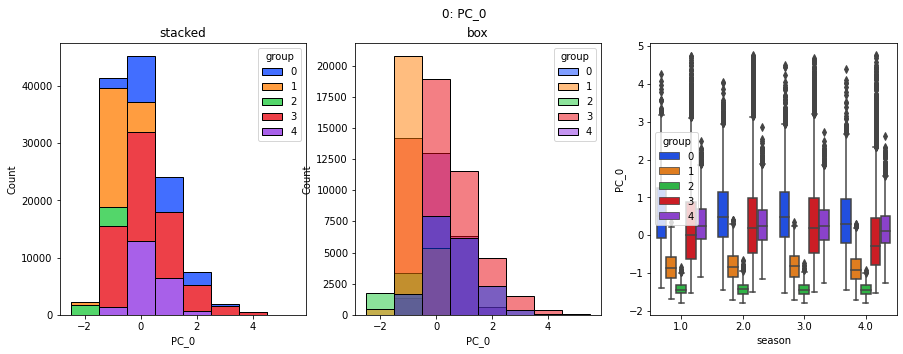

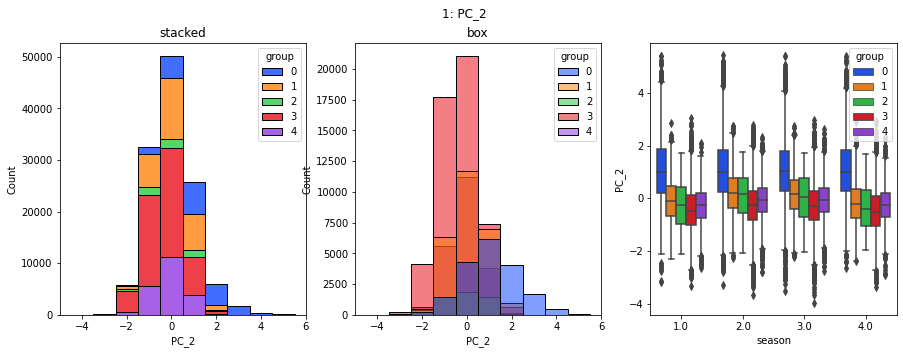

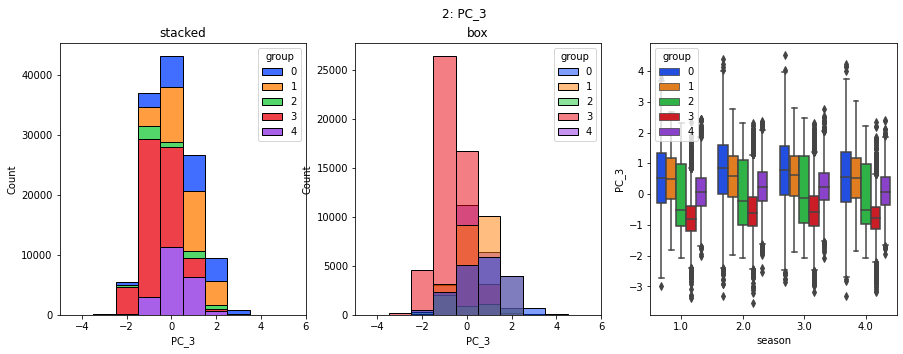

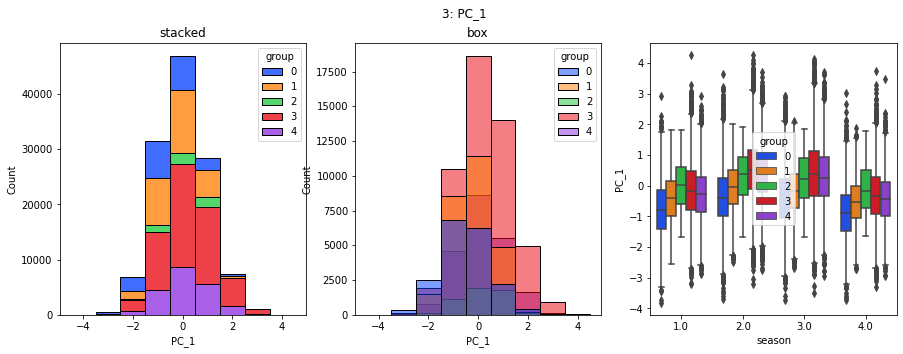

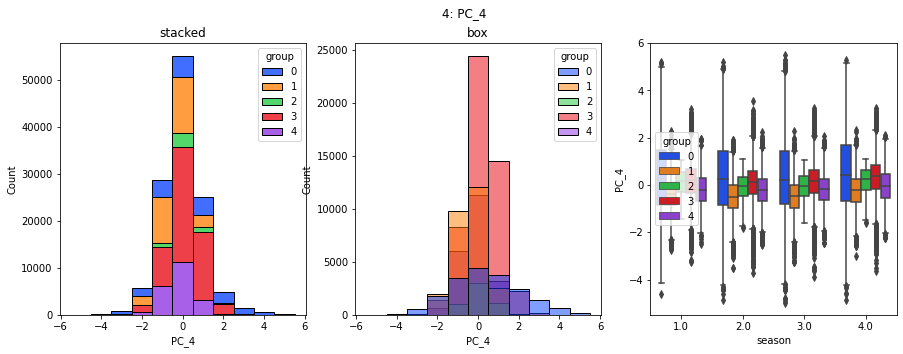

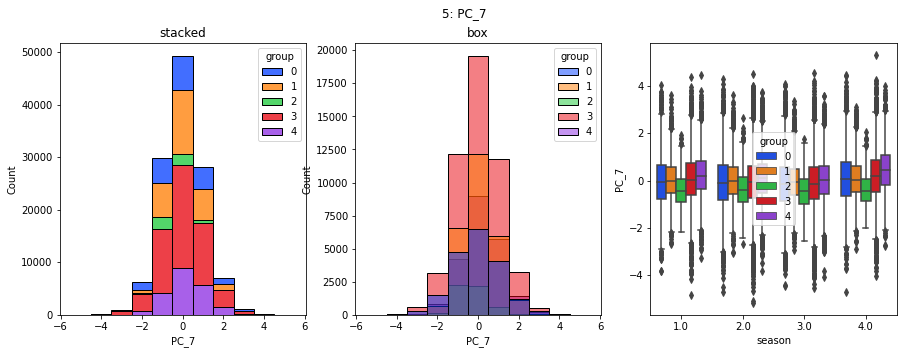

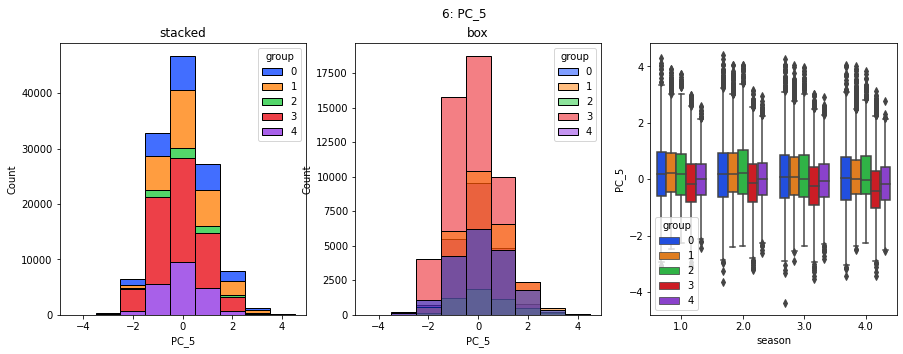

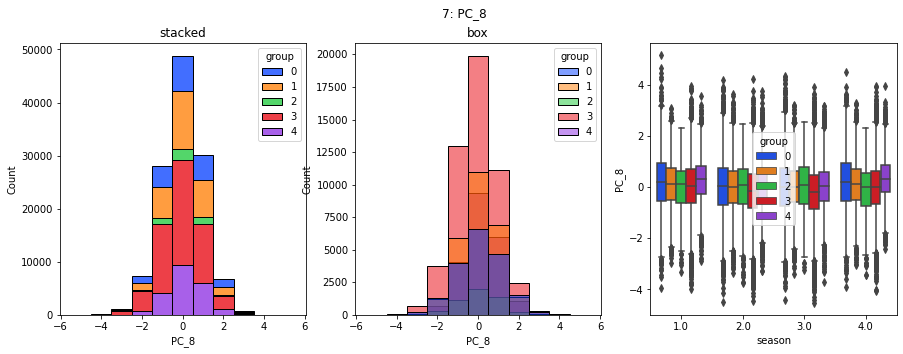

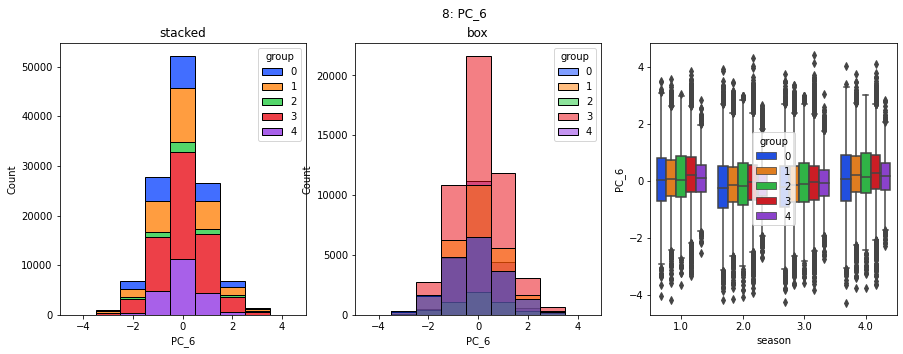

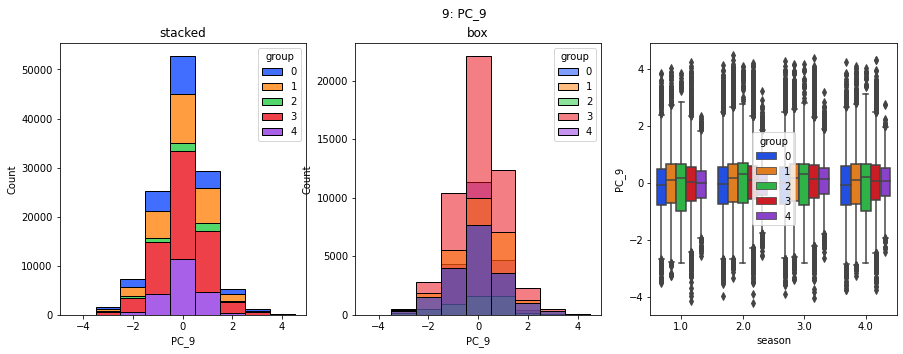

In [ ]:
for i, col in enumerate(top_cols):
    fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharey=False)
    fig.suptitle(str(i)+': ' + col)
    sns.histplot(data=df.round(), x=col, hue="group", discrete=True, multiple="stack",ax=axes[0], palette='bright')
    axes[0].set_title('stacked')
    sns.histplot(data=df.round(), x=col, hue="group", discrete=True,ax=axes[1], palette='bright')
    axes[1].set_title('transparent')
    sns.boxplot(x="season", y=col, hue="group",data=df, ax=axes[2], palette='bright')
    axes[1].set_title('box')
    plt.show()

# Plot specific answers

## Create GIF

In [ ]:
df_timeframe = df.copy()
df_timeframe['date'] = pd.to_datetime(df_timeframe['date'])

plt.ioff()
for nr_weeks in range(52):
  dt_start_temp = df_timeframe.date.min() + timedelta(days=7) * nr_weeks
  dt_end_temp = dt_start_temp + timedelta(days=14)
  time_window = (df_timeframe['date'] > dt_start_temp) & (df_timeframe['date'] < dt_end_temp)
  df_timeframe_temp = df_timeframe[time_window]


  g = sns.JointGrid(data=df_timeframe_temp, x=top_cols[0], y=top_cols[1], hue="group", palette='bright', height=8) # hue_order=[1, 2, 0],
  g.plot_joint(sns.kdeplot, alpha=0.8) #or scatterplot #kdeplot
  g.plot_marginals(sns.histplot, kde=True) #or kdeplot
  fig = g.fig
  fig.suptitle(dt_start_temp.strftime("%Y-%m-%d") + ' - ' + dt_end_temp.strftime("%Y-%m-%d"))
  fig.savefig("gif_creation/images/out_"+dt_start_temp.strftime("%Y_%m_%d") + ".png")
  plt.close(fig)

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:1213: UserWarning: No contour levels were found within the data range.
  **contour_kws,


In [ ]:
# Create GIF
images = []
path = 'gif_creation/images/'

for filename in os.listdir(path):
  images.append(imageio.imread(path+filename))
  os.remove(path+filename)
imageio.mimsave('gif_creation/gmm_pca.gif', images, duration=0.5)

## Plot

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:1106: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)


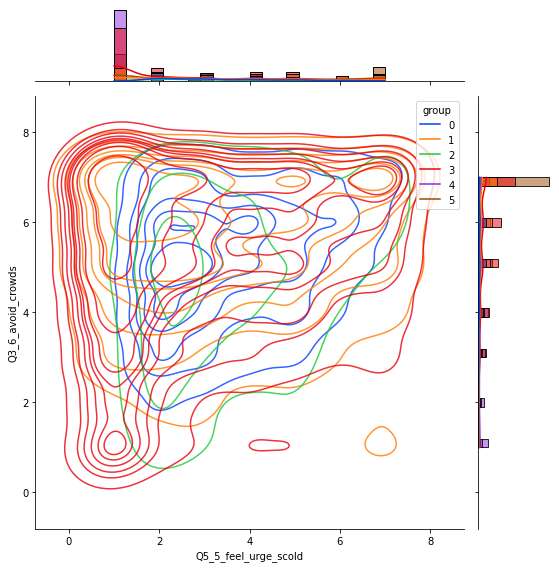

In [11]:
df_timeframe = df.sample(10000)

g = sns.JointGrid(data=df_timeframe, x=top_cols[0], y=top_cols[1], hue="group", palette='bright', height=8) # hue_order=[1, 2, 0],
g.plot_joint(sns.kdeplot, alpha=0.8) #or scatterplot
g.plot_marginals(sns.histplot, kde=True) #or kdeplot

In [ ]:
start = '2020-12-01'
end = '2021-02-28'
df_sample.date = pd.to_datetime(df_sample.date)
in_range = (df_sample.date > start) & (df_sample.date < end)
df_sample_timewindow = df_sample[in_range]

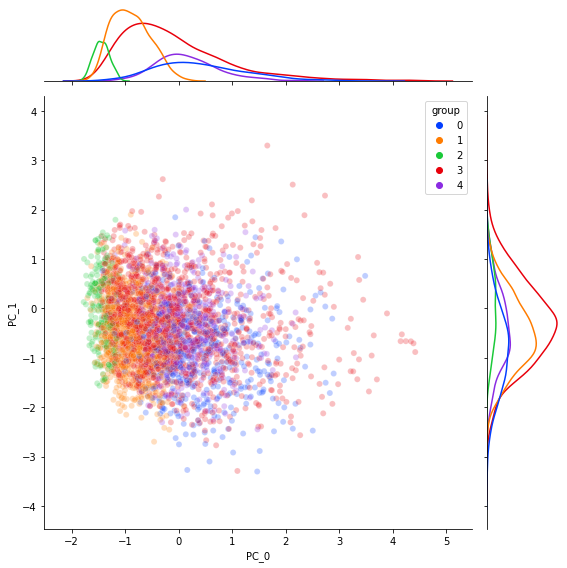

In [ ]:
g = sns.JointGrid(data=df_sample_timewindow, x='PC_0', y='PC_1', hue="group", palette='bright', height=8) # hue_order=[1, 2, 0],
g.plot_joint(sns.scatterplot, alpha=0.25) #or scatterplot
g.plot_marginals(sns.kdeplot) #or kdeplot

In [ ]:
df_sample_timewindow.group = df_sample_timewindow.group.astype(str)
fig = px.scatter_3d(df_sample_timewindow, x='PC_0', y='PC_1', z='PC_2', color='group', opacity=1)
fig.update_layout(
    scene = dict(
        xaxis = dict(nticks=5, range=[-5,5],),
                     yaxis = dict(nticks=5, range=[-5,5],),
                     zaxis = dict(nticks=5, range=[-5,5],),),
        width=700, margin=dict(r=20, l=10, b=10, t=10))
fig.show()

/usr/local/lib/python3.7/dist-packages/pandas/core/generic.py:5516: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



# Group distance # change so that it takes multiple groups into account

In [ ]:
df_dict = []
for i, day in  df[behaviour_cols + ['date', 'group']].groupby(['date']):
     groups_dist = np.abs(day[day['group']== 0].mean() - day[day['group']== 1].mean())
     dist = np.linalg.norm(groups_dist.values, ord=1)
     df_dict.append({'time':i, 'distance': dist})
dist_df = pd.DataFrame(df_dict)
dist_df['dist_smooth'] = dist_df.distance.rolling(7).mean()
fig = px.line(dist_df,x='time', y=['distance', 'dist_smooth'])
fig.show()

# Plot Group Sizes

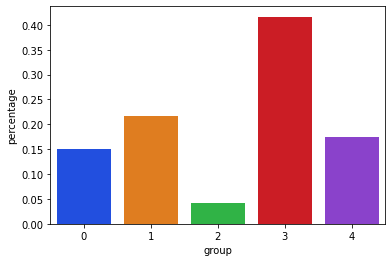

In [ ]:
df_group_size = df[['group', 'gender']].groupby('group').count().reset_index()
df_group_size['gender'] = df_group_size['gender'] / df_group_size['gender'].sum()
df_group_size.rename(columns={'gender':'percentage'}, inplace=True)
sns.barplot(data=df_group_size, x='group', y='percentage', palette='bright')

# Daily distribution

In [ ]:
groups_percentage = df.groupby(['date','group'],as_index=False)['gender'].count()
def normalize(row):
  sum = groups_percentage[groups_percentage['date']==row['date']]['gender'].sum()
  return row['gender']/sum

groups_percentage['percentage'] = groups_percentage.apply(lambda x: normalize(x), axis=1)
groups_percentage['date'] = pd.to_datetime(groups_percentage['date'])
groups_percentage.drop(columns='gender',inplace=True)
#fig = px.line(groups_percentage, x="date", y="percentage", color='group', title='Group daily distribution')
#fig.show()

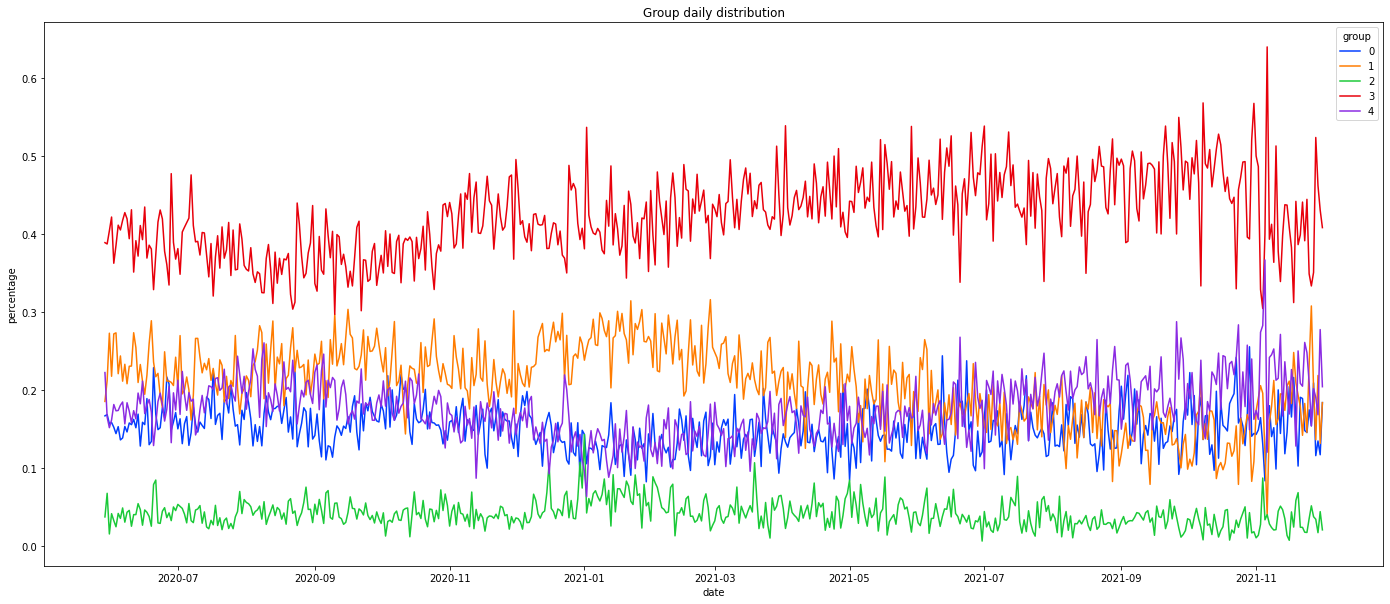

In [ ]:
fig, ax = plt.subplots(figsize=(24, 10))
sns.lineplot(data=groups_percentage, x='date', y='percentage', hue='group', palette="bright", ax=ax)
plt.title('Group daily distribution')
plt.show()

# Daily Average Group Answer

In [ ]:
df_daily_average = df.groupby(['date','group']).mean().reset_index()
df_daily_average.date = pd.to_datetime(df_daily_average.date)
for col in df_daily_average.columns:
    sns.lineplot(data=df_daily_average, x='date', y=col, hue='group', palette="bright")
    plt.title(col)
    plt.show()

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
df_daily_average = df.groupby(['date','group']).mean().reset_index()
df_daily_average_0 = df_daily_average[df_daily_average.group == 0]
df_daily_average_1 = df_daily_average[df_daily_average.group == 1]
for col in df_daily_average_0.columns:
    plt.plot(df_daily_average_0.date,df_daily_average_0[col], label='0')
    plt.plot(df_daily_average_1.date,df_daily_average_1[col], label='1')
    plt.legend()
    plt.title(col)
    plt.show()

# Observations

In [ ]:
observations = pd.read_csv('data/observations_30012022.csv',sep=';', decimal=',', encoding='utf-8')
sliced_observations = observations.iloc[92:643]
fig = px.line(sliced_observations, x="Date", y=sliced_observations.columns[2:])
fig.show()

# Archive

In [ ]:
"""for blickwinkel in np.arange(0, 270, 30):

  fig = plt.figure(figsize=(8, 8))

  ax = plt.axes(projection='3d')
  color_list = ['red', 'green', 'blue', 'yellow', 'grey']
  i=0
  x_name = top_3_cols[0]#'PC_0'
  y_name = top_3_cols[1]#'PC_3'
  z_name = top_3_cols[2]#'PC_2'
  for group in df_sample['group'].unique().tolist():
    x = df_sample[df_sample['group']==group][x_name]
    y = df_sample[df_sample['group']==group][y_name]
    z = df_sample[df_sample['group']==group][z_name]
    ax.scatter3D(x, y, z, alpha=0.1, color=color_list[i], label=str(group))
    ax.set_title('Blickwinkel: ' + str(blickwinkel) + ' Grad')
    i = i+1
  ax.legend()
  ax.set_xlabel(x_name)
  ax.set_ylabel(y_name)
  ax.set_zlabel(z_name)

  ax.azim = blickwinkel #90 #135 #180 #225 #270
  ax.elev = 40"""